# Perform Calibration Measurement for Cross Validated Models

In this example, we demonstrate how to perform Calibration measurements (both 1-calibration and D-calibration) for cross validated models.

One possible choice could be performing calibration evaluation on each fold and count how many times does the model calibrated.
For example, say the D-calibration p-values for 5-fold cross validation are [0.01, 0.10, 0.98, 0.75, 0.25].
We can use the threshold of 0.05 to conclude that the model is calibrated 4 times.

On the other hand, if one wants to get an overall performance score on the whole dataset, it is not appropriate to average on the p-values over the folds (like we normally compute a mean and standard deviation for concordance or Brier scores).
It is because p-values are not designed to be compared (it should only be used to accept or reject the hypothesis).
Instead, we can combine the predicted survival curves from all cross-validation folds, and perform the calibration test on the total curves.
This method is suggested in section 4.1 at [Haider's JMLR paper]((https://jmlr.org/papers/volume21/18-772/18-772.pdf)).

This tutorial will implement the second method described above, which will only result a single p-value at the end.

In [1]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Evaluator import LifelinesEvaluator
from Evaluations.util import stratified_folds_survival

In [2]:
%matplotlib inline

## Load the dataset.

In [3]:
np.random.seed(42)
rossi = load_rossi()

## Perform 5-fold cross validation on the whole dataset.
We divide the folds using customized function so that each fold will have roughly the same distribution of times and censorships.

We iteratively concatenate the predicted survival curves in each fold. And we have to do the same thing for event indicators and event times of testing set.

In [4]:
total_surv = pd.DataFrame()
total_durations = np.empty([0, ])
total_events = np.empty([0, ])

for data_train, data_test in tqdm(stratified_folds_survival(rossi, rossi.week.values, rossi.arrest.values)):
    durations_test = data_test['week'].values
    events_test = data_test['arrest'].values.astype('bool')
    # Fit the model
    cph = CoxPHFitter()
    cph.fit(data_train, duration_col='week', event_col='arrest')
    survival_curves = cph.predict_survival_function(data_test, list(range(1, 53)))
    # Combine the curves
    total_surv = pd.concat([total_surv, survival_curves], axis=1)
    total_durations = np.concatenate([total_durations, durations_test], axis=0)
    total_events = np.concatenate([total_events, events_test], axis=0)

100%|██████████| 5/5 [00:00<00:00, 30.09it/s]


## Build the Evaluator.
Since none of the calibration measurements need training information, we can omit those and only input survival curves and testing information.

In [5]:
eval = LifelinesEvaluator(total_surv, total_durations, total_events)

## Run one calibration test at 50% time for the whole data set.

<Figure size 432x288 with 0 Axes>

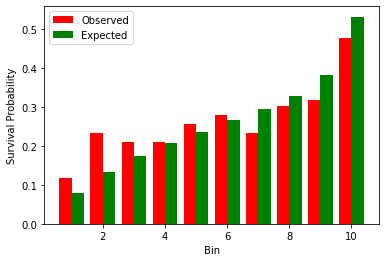

The cross validated model is one-calibrated at time 52.0.


In [6]:
one_cal_times = np.quantile(rossi['week'], 0.5)

p_value, obs_probs, exp_probs = eval.one_calibration(target_time=one_cal_times, method="DN")
# Returned probability are ranked from high to low. We want to draw the calibration bar plot from low to high.
bins = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

plt.clf()
fig, ax = plt.subplots()
bar1 = ax.bar([x - 0.2 for x in bins], obs_probs, width=0.4, color='r', align='center')
bar2 = ax.bar([x + 0.2 for x in bins], exp_probs, width=0.4, color='g', align='center')

ax.legend((bar1[0], bar2[0]), ('Observed', 'Expected'))
plt.ylabel("Survival Probability")
plt.xlabel("Bin")
plt.show()
if p_value >= 0.05:
    print("The cross validated model is one-calibrated at time {}.".format(one_cal_times))
else:
    print("The cross validated model is not one-calibrated at time {}.".format(one_cal_times))

## Run d-calibration test at 50% time for the whole data set.

<Figure size 432x288 with 0 Axes>

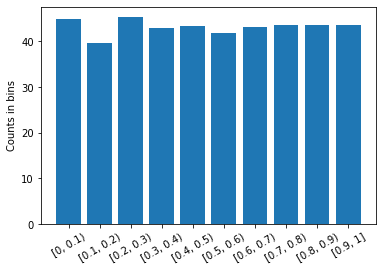

The cross validated model is d-calibrated!


In [7]:
p_value2, bin_statistics = eval.d_calibration()
bins = ["[0, 0.1)", "[0.1, 0.2)", "[0.2, 0.3)", "[0.3, 0.4)", "[0.4, 0.5)", "[0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)",
        "[0.8, 0.9)", "[0.9, 1]"]
plt.clf()
fig, ax = plt.subplots()
ax.bar(bins, bin_statistics)
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylabel("Counts in bins")
plt.show()
if p_value2 >= 0.05:
    print("The cross validated model is d-calibrated!")
else:
    print("The cross validated model is not d-calibrated!")